In [3]:
import pandas as pd
import numpy as np
import os

In [4]:
#os.chdir('D:/Penn/Career/Citadel/2021datathon')
match = pd.read_csv('../match_discrete_htwt_drop30.csv')
match['date']  = pd.to_datetime(match['date'])
df_clus = pd.read_csv('team_att_all_w_cluster_gmm24.csv')
df_clus['date']  = pd.to_datetime(df_clus['date'])

In [5]:
match.shape

(17581, 201)

In [6]:
Nc = df_clus['cluster'].max() + 1
Nc

24

In [7]:
def get_meta(team_id, date):
    df = df_clus[df_clus['team_id'] == team_id]

    # return -1 if there is no record of the team's meta
    if df.shape[0] == 0:
        return -1

    clus = df.iloc[0, :]['cluster']
    for i in range(1, df.shape[0]):
        if df.iloc[i, :]['date'] < date:
            clus = df.iloc[i, :]['cluster']
        else:
            break
    
    return clus

In [8]:
# The following matrices register information only on the upper half - i.e. i >= j
goal_mat = np.zeros((Nc, Nc)) # goal_mat[i][j] is the net # of goals meta i scored against meta j. Could be positive or negative
match_mat = np.zeros((Nc, Nc)) # match_mat[i][j] is the total # of matches meta i played against meta j

for row in range(match.shape[0]):
    h_meta = get_meta(match['home_team_id'].loc[row], match['date'].loc[row])
    if h_meta < 0:
        continue
    a_meta = get_meta(match['away_team_id'].loc[row], match['date'].loc[row])
    if a_meta < 0:
        continue

    if h_meta < a_meta:
        match_mat[h_meta, a_meta] += 1
        goal_mat[h_meta, a_meta] += match['home_team_goal'].loc[row] - match['away_team_goal'].loc[row]
    else:
        match_mat[a_meta, h_meta] += 1
        goal_mat[a_meta, h_meta] += match['away_team_goal'].loc[row] - match['home_team_goal'].loc[row]

In [9]:
print(match_mat)
print(goal_mat)

[[  4.   0.  36.   1.  75.  29.  25.   0.   0.  16.   0.  28.   0.  11.
    2.   0.   0.   0.   5.   0. 142.  24.   0.   0.]
 [  0. 783. 371. 155.   0.  25. 264.   0.  18.  11.  35.   2.   0.  39.
    0.  22.   0.   0. 274.   0.   0.   4.  70.   0.]
 [  0.   0. 114.  45. 157. 168. 375.   0.  11.  63.   6.  64.   0.  72.
   43.   8.   0.   0. 263.   0.  54. 165. 169.   0.]
 [  0.   0.   0. 169.   0.   3.  24.  20.  54.   2.  15.   0.   0.  42.
    0. 268.  32.  28.  90.   0.  19.  32.  14.   9.]
 [  0.   0.   0.   0. 138.   0. 131.   0.   0.   0.   0. 121.   0.   6.
    0.   0.   0.   0.  16.   0.  14. 139.   0.   0.]
 [  0.   0.   0.   0.   0. 646. 165.   1.  37. 220.   0.  54.   0.   8.
  313.   0.   3.   0.  73.   2.  19.   1.   0.  21.]
 [  0.   0.   0.   0.   0.   0. 281.   0.  17. 117.  34.  56.   0.  75.
   36.   4.   0.   0. 127.   0.  66. 183. 474.   0.]
 [  0.   0.   0.   0.   0.   0.   0. 241.   0.   0.   0.   0.   0.  16.
    0.   0. 151.  77.  12.  29.  34.  11.   0. 165.]


In [10]:
meta_mat = np.divide(goal_mat, match_mat, out = np.zeros_like(match_mat), where = match_mat != 0)
np.set_printoptions(precision = 3)
print(meta_mat)

[[-0.75   0.     1.028  4.     1.387  1.621  1.16   0.     0.     0.25
   0.     1.357  0.     0.909  2.5    0.     0.     0.     0.8    0.
   1.141  1.042  0.     0.   ]
 [ 0.    -0.432 -1.008  0.077  0.    -0.16  -0.455  0.    -0.778 -1.364
   1.057 -1.     0.    -0.692  0.     0.091  0.     0.     0.099  0.
   0.    -0.75  -0.214  0.   ]
 [ 0.     0.    -0.675  1.267  0.662  0.839  0.709  0.     0.455 -0.206
   1.833  0.344  0.     0.569  0.837  2.625  0.     0.     1.331  0.
   0.148  0.248  1.574  0.   ]
 [ 0.     0.     0.    -0.414  0.    -1.    -0.333 -0.95  -0.741 -2.5
   0.6    0.     0.    -0.405  0.     0.381 -1.188 -0.857 -0.322  0.
   0.    -1.062  0.071 -1.333]
 [ 0.     0.     0.     0.    -0.275  0.    -0.595  0.     0.     0.
   0.    -0.19   0.    -0.833  0.     0.     0.     0.    -0.125  0.
  -0.357 -0.417  0.     0.   ]
 [ 0.     0.     0.     0.     0.    -0.285 -1.067  2.    -0.73  -1.345
   0.    -0.241  0.     1.    -0.46   0.    -1.333  0.     0.068  0.5
  -0

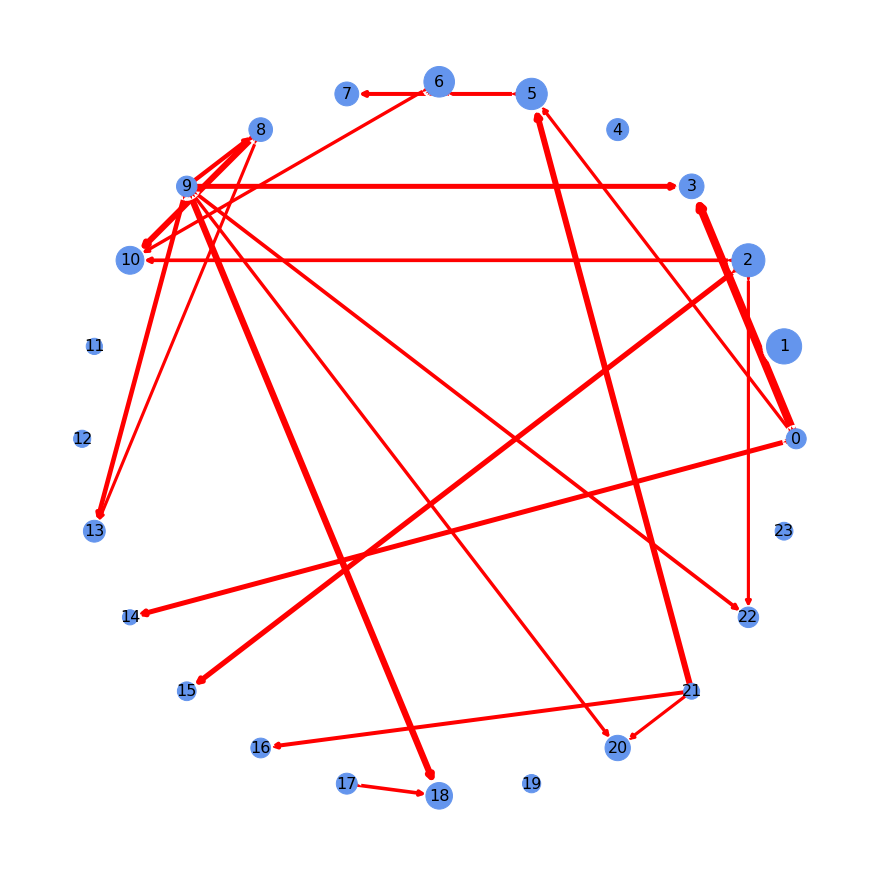

In [15]:
import networkx as nx
import matplotlib.pyplot as plt

wt_fac = 2
nd_base = 200
nd_fac = 0.5

G = nx.DiGraph()
wt_thr = np.percentile(abs(meta_mat), 75)

'''
Params to Change
'''
threshold=1.5
for i in range(0, Nc):
    for j in range(i, Nc):
        color = 'red' if abs(meta_mat[i, j]) > wt_thr else 'black'
        if meta_mat[i, j] > threshold:
            G.add_edge(i, j, weight = meta_mat[i, j] * wt_fac, color = color)
        elif meta_mat[i, j] < -threshold:
            G.add_edge(j, i, weight = -meta_mat[i, j] * wt_fac, color = color)
        else:
            G.add_edge(j, i, weight = 0, color = "white",alpha=0.1)
pos = nx.circular_layout(G)
edges = G.edges()
weights = [G[u][v]['weight'] for u, v in edges]
colors = [G[u][v]['color'] for u, v in edges]

plt.figure(figsize=(12,12)) 
nx.draw(G, pos, width = weights, with_labels = True, \
    node_size = np.array([sum(match_mat[i]) for i in range(Nc)]) * nd_fac + nd_base, \
    node_color='cornflowerblue', font_size = 16, edge_color = colors)

'''
Params to Change
'''
name="gmm24.png"
plt.savefig(name)
plt.show()


In [16]:
clus_expl=df_clus['cluster']
df_clus_expl=df_clus[[x for x in df_clus.columns if x not in ['team_id','date','next_date','Unnamed: 0','cluster']]]
df_clus_expl.head()

,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth,buildUpPlayPositioningClass_Free Form,buildUpPlayPositioningClass_Organised,...,preferred_foot_right,preferred_foot_left,attacking_work_rate_medium,attacking_work_rate_high,attacking_work_rate_low,defensive_work_rate_medium,defensive_work_rate_high,defensive_work_rate_low,height,weight
0,70,70,70,70,70,60,70,70,0,1,...,77.105263,22.894737,0.720624,0.202475,0.076901,0.793745,0.188565,0.017690,182.125832,163.418926
1,47,52,53,48,52,47,47,52,0,1,...,65.318182,32.181818,0.769388,0.105253,0.100360,0.831446,0.128958,0.014596,181.284803,164.746970
2,58,62,45,70,55,40,40,60,0,1,...,56.793388,41.388430,0.741781,0.121579,0.118457,0.844389,0.043324,0.094105,181.774645,160.814587
3,62,45,40,50,55,42,42,60,0,1,...,56.631177,43.368823,0.708245,0.165465,0.126290,0.832569,0.090964,0.076467,180.163178,158.986350
4,58,62,56,68,57,41,42,60,0,1,...,63.516746,36.483254,0.666268,0.243301,0.090431,0.736124,0.133493,0.130383,179.556124,160.926901


In [24]:
from sklearn.tree import _tree, DecisionTreeClassifier
from IPython.display import display, HTML

def pretty_print(df):
    return display( HTML( df.to_html().replace("\\n","<br>") ) )

def get_class_rules(tree: DecisionTreeClassifier, feature_names: list):
    inner_tree: _tree.Tree = tree.tree_
    classes = tree.classes_
    class_rules_dict = dict()

    def tree_dfs(node_id=0, current_rule=[]):
        # feature[i] holds the feature to split on, for the internal node i.
        split_feature = inner_tree.feature[node_id]
        if split_feature != _tree.TREE_UNDEFINED: # internal node
            name = feature_names[split_feature]
            threshold = inner_tree.threshold[node_id]
            # left child
            left_rule = current_rule + ["({} <= {})".format(name, format(threshold, ".3f"))]
            tree_dfs(inner_tree.children_left[node_id], left_rule)
            # right child
            right_rule = current_rule + ["({} > {})".format(name, format(threshold, ".3f"))]
            tree_dfs(inner_tree.children_right[node_id], right_rule)
        else: # leaf
            dist = inner_tree.value[node_id][0]
            dist = dist/dist.sum()
            max_idx = dist.argmax()
            if len(current_rule) == 0:
                rule_string = "ALL"
            else:
                rule_string = " and ".join(current_rule)
            # register new rule to dictionary
            selected_class = classes[max_idx]
            class_probability = dist[max_idx]
            class_rules = class_rules_dict.get(selected_class, [])
            class_rules.append((rule_string, class_probability))
            class_rules_dict[selected_class] = class_rules
    
    tree_dfs() # start from root, node_id = 0
    return class_rules_dict

'''
Params to Change
'''
# make Decision Tree
min_samples_leaf=5
pruning_level=0
max_depth=8
tree = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf, ccp_alpha=pruning_level,max_depth=max_depth)
tree.fit(df_clus_expl,clus_expl)

# get decision tree rules
feature_names = df_clus_expl.columns
class_rule_dict = get_class_rules(tree, feature_names)

report_class_list = []
for class_name in class_rule_dict.keys():
    rule_list = class_rule_dict[class_name]
    combined_string = ""
    for rule in rule_list:
        combined_string += "Proportion:[{}]\n {}\n\n".format(format(rule[1], ".3f"), rule[0])
    report_class_list.append((class_name, combined_string))

cluster_instance_df = pd.Series(clus_expl).value_counts().reset_index()
cluster_instance_df.columns = ['class_name', 'instance_count']
report_df = pd.DataFrame(report_class_list, columns=['class_name', 'rule_list'])
report_df = pd.merge(cluster_instance_df, report_df, on='class_name', how='left')
pretty_print(report_df.sort_values(by='class_name')[['class_name', 'instance_count', 'rule_list']])

,class_name,instance_count,rule_list
23,0,11,Proportion:[1.000] (gk_kicking <= 22.170) and (defenceDefenderLineClass_Offside Trap <= 0.500) and (reactions > 69.111) and (buildUpPlayDribbling <= 40.750) and (buildUpPlayPassing <= 46.500) and (curve <= 63.597) and (sliding_tackle > 54.603) and (acceleration > 72.706)Proportion:[0.429] (gk_kicking <= 22.170) and (defenceDefenderLineClass_Offside Trap <= 0.500) and (reactions > 69.111) and (buildUpPlayDribbling <= 40.750) and (buildUpPlayPassing > 46.500) and (reactions > 76.318) and (positioning > 61.172)Proportion:[0.600] (gk_kicking <= 22.170) and (defenceDefenderLineClass_Offside Trap <= 0.500) and (reactions > 69.111) and (buildUpPlayDribbling > 40.750) and (long_shots > 60.619) and (buildUpPlayDribbling <= 46.250) and (gk_diving <= 16.150)
3,1,70,Proportion:[0.889] (gk_kicking <= 22.170) and (defenceDefenderLineClass_Offside Trap <= 0.500) and (reactions <= 69.111) and (volleys <= 42.240) and (reactions > 63.576) and (finishing <= 45.219)Proportion:[0.800] (gk_kicking <= 22.170) and (defenceDefenderLineClass_Offside Trap <= 0.500) and (reactions <= 69.111) and (volleys > 42.240) and (shot_power <= 58.297) and (short_passing <= 60.942) and (shot_power <= 55.560)Proportion:[1.000] (gk_kicking <= 22.170) and (defenceDefenderLineClass_Offside Trap <= 0.500) and (reactions <= 69.111) and (volleys > 42.240) and (shot_power <= 58.297) and (short_passing > 60.942) and (stamina <= 67.547)Proportion:[0.625] (gk_kicking <= 22.170) and (defenceDefenderLineClass_Offside Trap <= 0.500) and (reactions <= 69.111) and (volleys > 42.240) and (shot_power <= 58.297) and (short_passing > 60.942) and (stamina > 67.547)Proportion:[0.500] (gk_kicking <= 22.170) and (defenceDefenderLineClass_Offside Trap <= 0.500) and (reactions <= 69.111) and (volleys > 42.240) and (shot_power > 58.297) and (standing_tackle > 52.708) and (buildUpPlayDribbling > 40.750) and (heading_accuracy > 59.945)
5,2,57,Proportion:[0.333] (gk_kicking <= 22.170) and (defenceDefenderLineClass_Offside Trap <= 0.500) and (reactions > 69.111) and (buildUpPlayDribbling > 40.750) and (long_shots > 60.619) and (buildUpPlayDribbling > 46.250) and (penalties > 56.711) and (jumping <= 68.987)Proportion:[0.975] (gk_kicking <= 22.170) and (defenceDefenderLineClass_Offside Trap <= 0.500) and (reactions > 69.111) and (buildUpPlayDribbling > 40.750) and (long_shots > 60.619) and (buildUpPlayDribbling > 46.250) and (penalties > 56.711) and (jumping > 68.987)
8,3,41,Proportion:[0.333] (gk_kicking <= 22.170) and (defenceDefenderLineClass_Offside Trap <= 0.500) and (reactions <= 69.111) and (volleys <= 42.240) and (reactions > 63.576) and (finishing > 45.219)Proportion:[0.333] (gk_kicking <= 22.170) and (defenceDefenderLineClass_Offside Trap <= 0.500) and (reactions <= 69.111) and (volleys > 42.240) and (shot_power <= 58.297) and (short_passing <= 60.942) and (shot_power > 55.560) and (ball_control <= 59.422)Proportion:[0.786] (gk_kicking <= 22.170) and (defenceDefenderLineClass_Offside Trap <= 0.500) and (reactions <= 69.111) and (volleys > 42.240) and (shot_power > 58.297) and (standing_tackle <= 52.708) and (curve <= 49.088) and (preferred_foot_right > 75.798)Proportion:[0.226] (gk_kicking <= 22.170) and (defenceDefenderLineClass_Offside Trap <= 0.500) and (reactions <= 69.111) and (volleys > 42.240) and (shot_power > 58.297) and (standing_tackle <= 52.708) and (curve > 49.088) and (vision > 57.996)Proportion:[0.200] (gk_kicking <= 22.170) and (defenceDefenderLineClass_Offside Trap <= 0.500) and (reactions > 69.111) and (buildUpPlayDribbling > 40.750) and (long_shots <= 60.619) and (weight <= 174.516) and (short_passing <= 63.706) and (ball_control <= 63.612)
11,4,29,Proportion:[0.429] (gk_kicking <= 22.170) and (defenceDefenderLineClass_Offside Trap <= 0.500) and (reactions <= 69.111) and (volleys > 42.240) and (shot_power > 58.297) and (standing_tackle > 52.708) and (buildUpPlayDribbling <= 40.750) and (stamina <= 67.769)Proportion:[0.733] (g

In [25]:
'''
Params to Change
'''
report_df.to_csv("expl_gmm24.csv")